In [1]:
!pip install keras

In [25]:
import numpy as np
import os
import cv2
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from keras import backend as K

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import DenseNet121
from keras.losses import binary_crossentropy

import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [27]:
# All the images will be converted to the same size before processing
img_h, img_w = 120, 120

def preprocess_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

    # Check if the image is empty or None
    if image is None or len(image) == 0:
        print(f"Error: Image {img_path} is empty or None.")
        return None

    # Check if the image has valid dimensions
    if image.shape[0] == 0 or image.shape[1] == 0:
        print(f"Error: Image {img_path} has invalid dimensions.")
        return None

    # Resize image
    image = cv2.resize(image, (img_h, img_w))

    # Convert grayscale to RGB by replicating the channel
    image = cv2.merge((image, image, image))

    # Normalize pixel values
    image = image.astype('float32') / 255.0
    return image

def generate_batch(orig_groups, forg_groups, batch_size=32):
    while True:
        pairs = [np.zeros((batch_size, img_h, img_w, 3)) for _ in range(2)]
        targets = np.zeros((batch_size,))

        for i in range(batch_size):
            if i < batch_size // 2:
                # Genuine-Genuine pairs
                pair_idx = np.random.randint(len(orig_groups), size=2)
                pair = (np.random.choice(orig_groups[pair_idx[0]]), np.random.choice(orig_groups[pair_idx[1]]))
                targets[i] = 1
            else:
                # Genuine-Forged pairs
                orig_idx = np.random.randint(len(orig_groups))
                orig = np.random.choice(orig_groups[orig_idx])
                forg = np.random.choice(forg_groups[orig_idx])
                pair = (orig, forg)
                targets[i] = 0

            # Preprocess images using preprocess_image function
            img1 = preprocess_image(pair[0])
            img2 = preprocess_image(pair[1])

            # Assign preprocessed images to pairs
            pairs[0][i, :, :, :] = img1
            pairs[1][i, :, :, :] = img2

        yield pairs, targets

# Load and preprocess data
path = "/content/drive/MyDrive/Multilingual dataset/CEDAR"
dir_list = next(os.walk(path))[1]

orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(os.path.join(path, directory))
    images.sort()
    images = [os.path.join(path, directory, x) for x in images]
    forg_groups.append(images[:24])
    orig_groups.append(images[24:])

# Split data into train, validation, and test sets
orig_train, orig_val_test, forg_train, forg_val_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=42)
orig_val, orig_test, forg_val, forg_test = train_test_split(orig_val_test, forg_val_test, test_size=0.5, random_state=42)

# Define Siamese network model with DenseNet121 base
def get_siamese_model(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add GlobalAveragePooling2D layer to reduce dimensions
    base_model = Sequential([
        base_model,
        GlobalAveragePooling2D()
    ])

    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([processed_a, processed_b])

    output = Dense(1, activation='sigmoid')(distance)

    model = Model(inputs=[input_a, input_b], outputs=output)
    return model

# Define batch size and generators
batch_size = 32
train_batch_generator = generate_batch(orig_train, forg_train, batch_size=batch_size)
val_batch_generator = generate_batch(orig_val_test, forg_val_test, batch_size=batch_size)
test_batch_generator = generate_batch(orig_test, forg_test, batch_size=batch_size)


# Compile model with binary cross-entropy loss
input_shape = (img_h, img_w, 3)  # Adjusted input shape for RGB
model = get_siamese_model(input_shape)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08))

# Define callbacks
callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Multilingual dataset/Weights/Cedar-Weights/cedar-{epoch:03d}.h5',
                    verbose=1, save_best_only=True, save_weights_only=True)
]

# Train model
num_train_samples = sum(len(group) for group in orig_train + forg_train)
num_val_samples = sum(len(group) for group in orig_val_test + forg_val_test)
batches_per_epoch_train = num_train_samples // batch_size
batches_per_epoch_val = num_val_samples // batch_size

# Calculate steps per epoch
steps_per_epoch_train = max(1, num_train_samples // batch_size)
steps_per_epoch_val = max(1, num_val_samples // batch_size)

results = model.fit(
    train_batch_generator,
    steps_per_epoch=steps_per_epoch_train,  # Use calculated steps per epoch
    epochs=5,
    validation_data=val_batch_generator,
    validation_steps=steps_per_epoch_val,  # Use calculated steps per epoch for validation
    callbacks=callbacks
)

Epoch 1/5
66/66 [==============================] - ETA: 0s - loss: 0.3637 
Epoch 1: val_loss improved from inf to 0.88538, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/Cedar-Weights/cedar-001.h5
66/66 [==============================] - 903s 13s/step - loss: 0.3637 - val_loss: 0.8854 - lr: 1.0000e-04
Epoch 2/5
66/66 [==============================] - ETA: 0s - loss: 0.0623 
Epoch 2: val_loss improved from 0.88538 to 0.62371, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/Cedar-Weights/cedar-002.h5
66/66 [==============================] - 843s 13s/step - loss: 0.0623 - val_loss: 0.6237 - lr: 1.0000e-04
Epoch 3/5
66/66 [==============================] - ETA: 0s - loss: 0.0217 
Epoch 3: val_loss improved from 0.62371 to 0.39676, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/Cedar-Weights/cedar-003.h5
66/66 [==============================] - 818s 12s/step - loss: 0.0217 - val_loss: 0.3968 - lr: 1.0000e-04
Epoch 4/5
66/66 [===

In [28]:
# Load best weights
model.load_weights('/content/drive/MyDrive/Multilingual dataset/Weights/Cedar-Weights/cedar-003.h5')

In [29]:
# Generate and print one batch from the training set
train_batch_inputs, train_batch_labels = next(train_batch_generator)
print("Training batch inputs shape:", train_batch_inputs[0].shape, train_batch_inputs[1].shape)
print("Training batch labels shape:", train_batch_labels.shape)

# Generate and print one batch from the validation set
val_batch_inputs, val_batch_labels = next(val_batch_generator)
print("Validation batch inputs shape:", val_batch_inputs[0].shape, val_batch_inputs[1].shape)
print("Validation batch labels shape:", val_batch_labels.shape)

# Generate and print one batch from the test set
test_batch_inputs, test_batch_labels = next(test_batch_generator)
print("Test batch inputs shape:", test_batch_inputs[0].shape, test_batch_inputs[1].shape)
print("Test batch labels shape:", test_batch_labels.shape)

Training batch inputs shape: (32, 120, 120, 3) (32, 120, 120, 3)
Training batch labels shape: (32,)
Validation batch inputs shape: (32, 120, 120, 3) (32, 120, 120, 3)
Validation batch labels shape: (32,)
Test batch inputs shape: (32, 120, 120, 3) (32, 120, 120, 3)
Test batch labels shape: (32,)


In [30]:
# Test model
test_batch_inputs, test_batch_labels = next(test_batch_generator)
predictions = model.predict(test_batch_inputs)

# Flatten predictions array
predictions_flat = predictions.flatten()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_batch_labels, predictions_flat)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold to predictions
predictions_binary = (predictions_flat > optimal_threshold).astype(int)

# Calculate metrics using the optimal threshold
accuracy = accuracy_score(test_batch_labels, predictions_binary)
precision = precision_score(test_batch_labels, predictions_binary)
recall = recall_score(test_batch_labels, predictions_binary)
f1 = f1_score(test_batch_labels, predictions_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

1/1 [==============================] - 7s 7s/step
Accuracy: 0.90625
Precision: 0.9333333333333333
Recall: 0.875
F1-Score: 0.9032258064516129


In [31]:
print("Optimal Threshold:", optimal_threshold)
print("ROC AUC:", roc_auc)

Optimal Threshold: 0.28405547
ROC AUC: 0.97265625


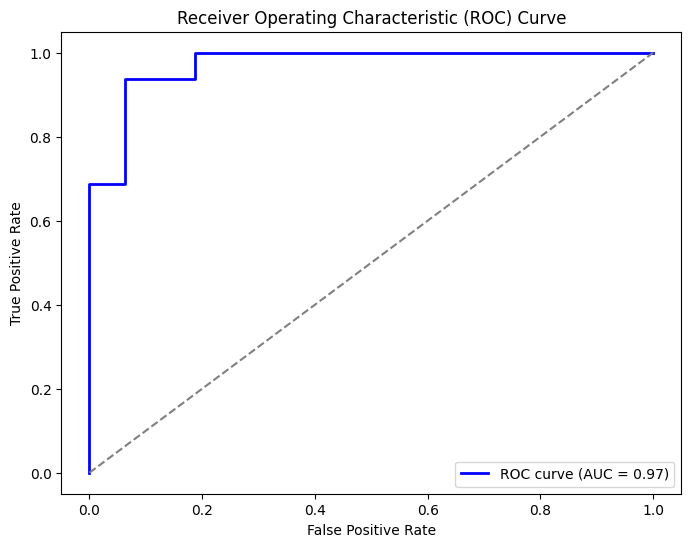

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_batch_labels, predictions)

# Compute ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 2s 2s/step


<ipython-input-42-f8cf05e75744>:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(img1, img2, multichannel=True)


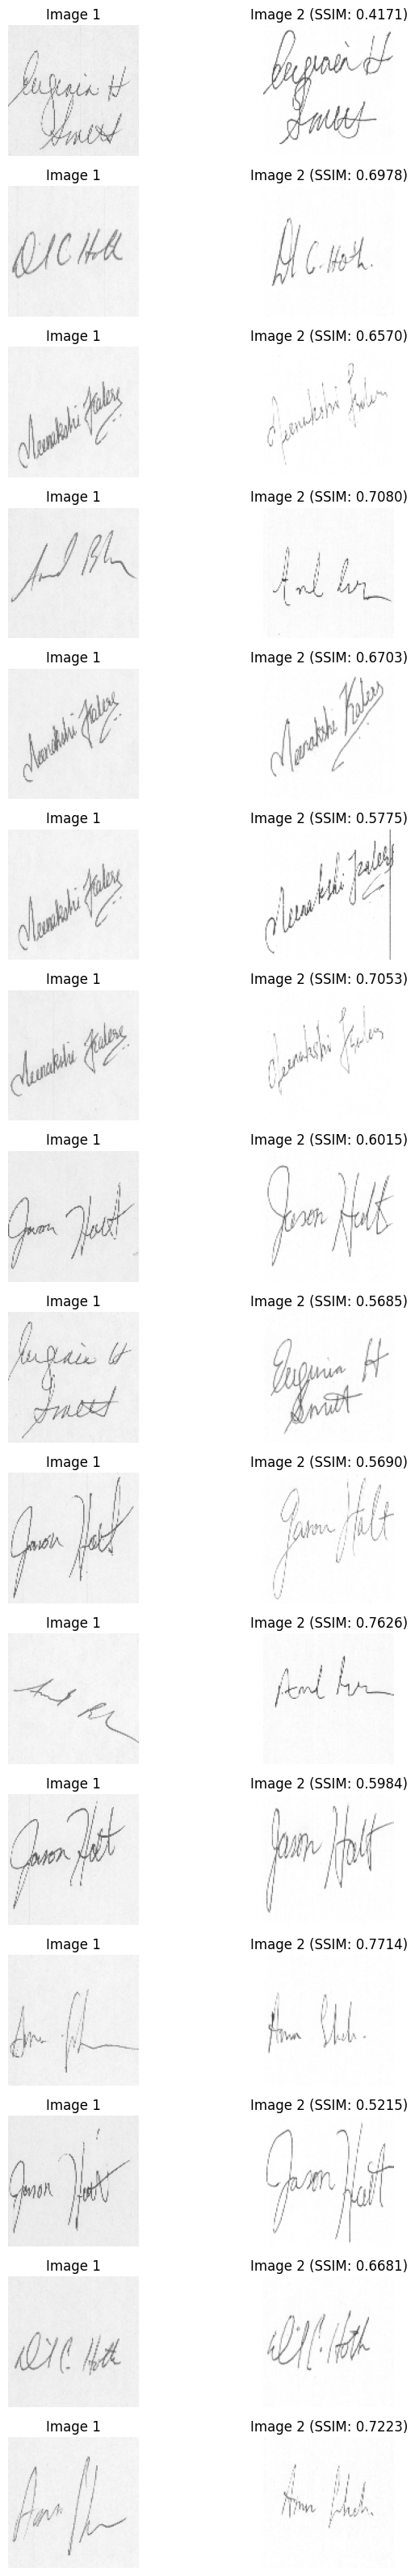

Average SSIM score: 0.6385107572524289


In [42]:
def display_genuine_forged_with_ssim(model, test_batch_generator, num_pairs=16):
    test_batch_inputs, test_batch_labels = next(test_batch_generator)
    predictions = model.predict(test_batch_inputs)

    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 2*num_pairs))
    genuine_forged_pairs = [(test_batch_inputs[0][i], test_batch_inputs[1][i], test_batch_labels[i]) for i in range(len(test_batch_labels)) if test_batch_labels[i] == 0]

    ssim_scores = []
    for i in range(num_pairs):
        img1, img2, label = genuine_forged_pairs[i]
        ssim_score = ssim(img1, img2, multichannel=True)
        ssim_scores.append(ssim_score)

        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"Image 1")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"Image 2 (SSIM: {ssim_score:.4f})")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate average SSIM score
    average_ssim = np.mean(ssim_scores)
    print("Average SSIM score:", average_ssim)

# Call the function to display genuine-forged image pairs with SSIM scores and print the average SSIM score
display_genuine_forged_with_ssim(model, test_batch_generator)

Higher SSIM scores imply lower dissimilarity between the images, while lower SSIM scores imply higher dissimilarity.

1/1 [==============================] - 2s 2s/step


<ipython-input-40-5056d88d5739>:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(img1, img2, multichannel=True)


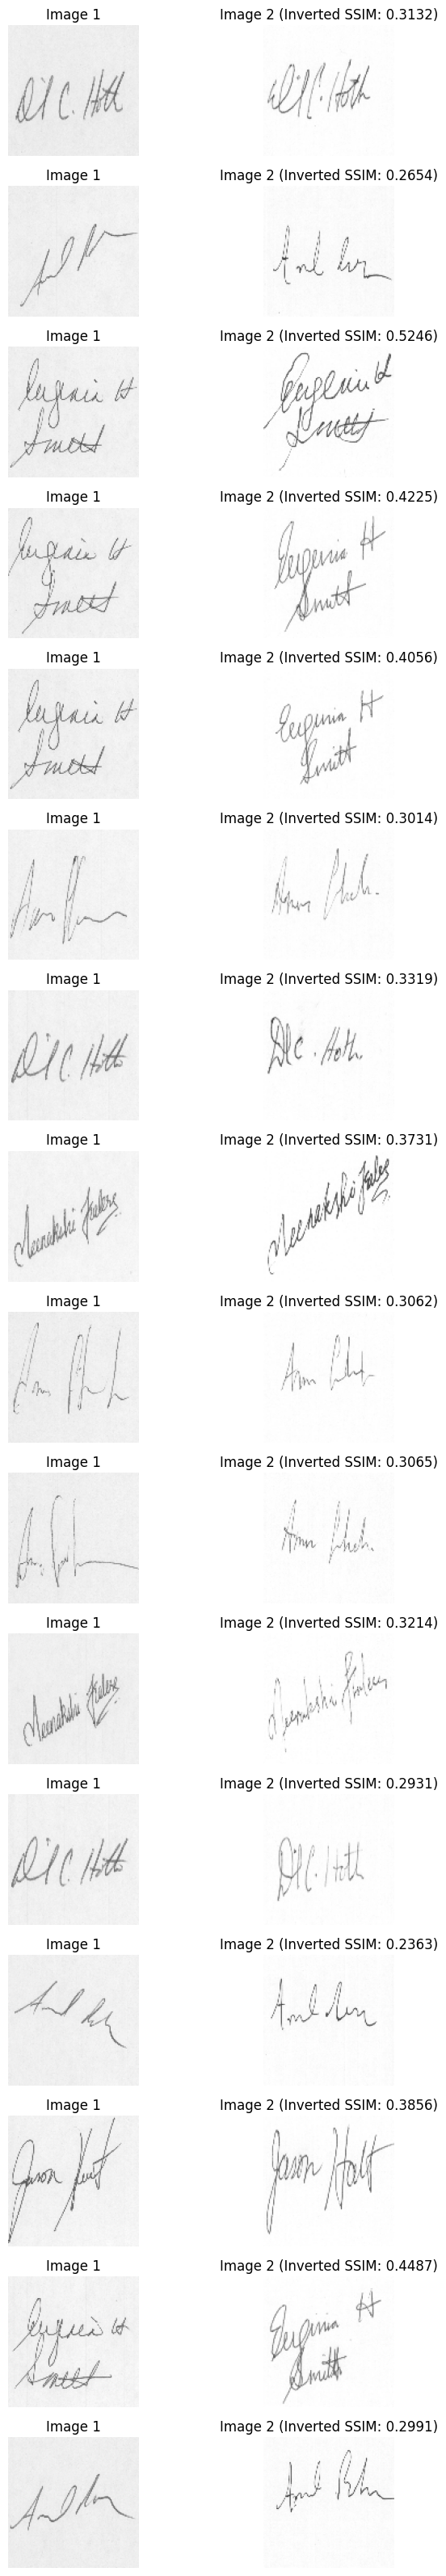

Average Inverted SSIM score: 0.34591398140279667


In [40]:
def display_genuine_forged_with_ssim(model, test_batch_generator, num_pairs=16):
    test_batch_inputs, test_batch_labels = next(test_batch_generator)
    predictions = model.predict(test_batch_inputs)

    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 2*num_pairs))
    genuine_forged_pairs = [(test_batch_inputs[0][i], test_batch_inputs[1][i], test_batch_labels[i]) for i in range(len(test_batch_labels)) if test_batch_labels[i] == 0]

    inverted_ssim_scores = []  # Store inverted SSIM scores

    for i in range(num_pairs):
        img1, img2, label = genuine_forged_pairs[i]
        ssim_score = ssim(img1, img2, multichannel=True)
        inverted_ssim_score = 1 - ssim_score  # Invert the SSIM score
        inverted_ssim_scores.append(inverted_ssim_score)

        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"Image 1")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"Image 2 (Inverted SSIM: {inverted_ssim_score:.4f})")  # Display inverted SSIM score
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate average inverted SSIM score
    average_inverted_ssim = np.mean(inverted_ssim_scores)
    print("Average Inverted SSIM score:", average_inverted_ssim)

# Call the function to display genuine-forged image pairs with inverted SSIM scores and print the average inverted SSIM score
display_genuine_forged_with_ssim(model, test_batch_generator)


In [33]:
# Print paths of all images in the test set
for orig_group, forg_group in zip(orig_test, forg_test):
    print("Originals:")
    for img_path in orig_group:
        print(img_path)
    print("Forged:")
    for img_path in forg_group:
        print(img_path)

Originals:
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_1.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_10.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_11.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_12.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_13.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_14.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_15.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_16.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_17.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_18.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_19.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_2.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_20.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/or

In [43]:
# predictions, and labels
print("Predictions:")
print(predictions)
print("Ground Truth Labels:")
print(test_batch_labels)

Predictions:
[[0.07617793]
 [0.6195807 ]
 [0.6809535 ]
 [0.5717231 ]
 [0.37074432]
 [0.84115887]
 [0.68207216]
 [0.7749967 ]
 [0.44994047]
 [0.9255645 ]
 [0.73442316]
 [0.701544  ]
 [0.44243214]
 [0.28405547]
 [0.49903536]
 [0.6576993 ]
 [0.02958229]
 [0.0192989 ]
 [0.03354149]
 [0.06479485]
 [0.03011439]
 [0.05982925]
 [0.47695974]
 [0.21142848]
 [0.01769145]
 [0.010166  ]
 [0.04644839]
 [0.06537642]
 [0.01586521]
 [0.00542858]
 [0.02750119]
 [0.20971347]]
Ground Truth Labels:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
